In [ ]:
# !pip install -U bitsandbytes transformers accelerate

In [2]:
import os
import sys

path = os.getcwd()
while True:
    if 'utils.py' in os.listdir(path):
        if path not in sys.path:
            sys.path.append(path)
        break
    new_path = os.path.dirname(path)
    if new_path == path:
        print("utils.py not found in any parent folder.")
        break
    path = new_path

import utils
from huggingface_hub import login
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch
import re
from sklearn.metrics import accuracy_score

c:\Users\User\anaconda3\envs\nlp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Login to HuggingFace
utils.hf_login()

In [ ]:
# Quantization Params
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4"
)

In [2]:
model_id = 'google/gemma-2-9b-it'

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    quantization_config=quantization_config,
    attn_implementation="eager"
    )


c:\Users\User\anaconda3\envs\nlp\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\User\.cache\huggingface\hub\models--google--gemma-2-9b-it. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP downlo

NameError: name 'quantization_config' is not defined

In [ ]:
# from google.colab import files
# uploaded = files.upload()
# TODO Make an env agnostic function that can load the csv
mnli_m_val = pd.read_csv('../../../Datasets/MNLI/mnli_m_val.csv')

mnli_m_val["label"] = mnli_m_val["label"].map({0: "entailment", 1: "neutral", 2: "contradiction"})

In [ ]:
mnli_m_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9815 entries, 0 to 9814
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   promptID                 9815 non-null   int64 
 1   pairID                   9815 non-null   object
 2   premise                  9815 non-null   object
 3   premise_binary_parse     9815 non-null   object
 4   premise_parse            9815 non-null   object
 5   hypothesis               9815 non-null   object
 6   hypothesis_binary_parse  9815 non-null   object
 7   hypothesis_parse         9815 non-null   object
 8   genre                    9815 non-null   object
 9   label                    9815 non-null   object
dtypes: int64(1), object(9)
memory usage: 766.9+ KB


In [ ]:
mnli_m_val.label.unique()

array(['neutral', 'contradiction', 'entailment'], dtype=object)

In [ ]:
mnli_m_val.head()

,promptID,pairID,premise,premise_binary_parse,premise_parse,hypothesis,hypothesis_binary_parse,hypothesis_parse,genre,label
0,63735,63735n,The new rights are nice enough,( ( The ( new rights ) ) ( are ( nice enough )...,(ROOT (S (NP (DT The) (JJ new) (NNS rights)) (...,Everyone really likes the newest benefits,( Everyone ( really ( likes ( the ( newest ben...,(ROOT (S (NP (NN Everyone)) (VP (ADVP (RB real...,slate,neutral
1,91383,91383c,This site includes a list of all award winners...,( ( This site ) ( ( includes ( ( ( ( a list ) ...,(ROOT (S (NP (DT This) (NN site)) (VP (VBZ inc...,The Government Executive articles housed on th...,( ( ( The ( Government ( Executive articles ) ...,(ROOT (S (NP (NP (DT The) (NNP Government) (NN...,government,contradiction
2,755,755e,uh i don't know i i have mixed emotions about ...,( ( ( ( uh ( i ( ( do n't ) ( know ( ( i i ) (...,(ROOT (SINV (S (S (INTJ (UH uh)) (NP (FW i)) (...,"I like him for the most part, but would still ...",( I ( ( ( ( ( ( like him ) ( for ( the ( most ...,(ROOT (S (NP (PRP I)) (VP (VP (VBP like) (NP (...,telephone,entailment
3,78013,78013c,yeah i i think my favorite restaurant is alway...,( yeah ( ( i i ) ( think ( ( my ( favorite res...,(ROOT (S (VP (VB yeah) (NP (NP (FW i) (FW i)) ...,My favorite restaurants are always at least a ...,( ( My ( favorite restaurants ) ) ( ( ( ( are ...,(ROOT (S (NP (PRP$ My) (JJ favorite) (NNS rest...,telephone,contradiction
4,96377,96377c,i don't know um do you do a lot of camping,( i ( ( do n't ) ( know ( um ( do ( you ( do (...,(ROOT (S (NP (FW i)) (VP (VBP do) (RB n't) (VP...,I know exactly.,( I ( ( know exactly ) . ) ),(ROOT (S (NP (PRP I)) (VP (VBP know) (ADVP (RB...,telephone,contradiction


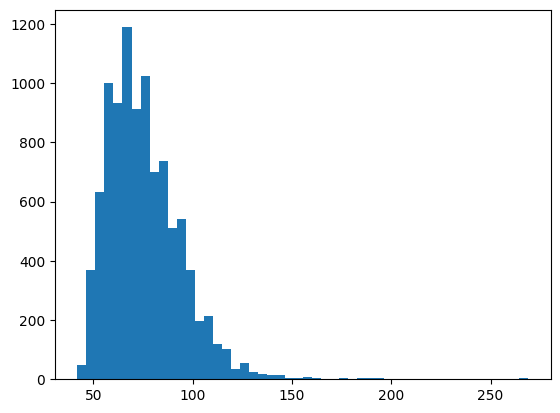

Max prompt length: 269
Max label length: 4


In [15]:
# Plot a histogram to find max_length of tokens
utils.find_max_length(mnli_m_val, tokenizer=tokenizer, dataset_type='mnli')

In [ ]:
prompt_lengths, _ = utils.get_lengths(mnli_m_val)
df = pd.DataFrame(prompt_lengths, columns=["length"])
print("Number of examples that have over 256 tokens:",(df["length"] > 256).sum())

Number of examples that have over 256 tokens: 5


Since we have only 5 examples that goes over a length of 256, we are going to use 256 as the default for `max_length` and miss some information in order to offload computing.

In [ ]:
# Test run for matched
utils.test_run(model=model, dataloader=dataloader, tokenizer=tokenizer, dataset_type="mnli")

neutral
contradiction
entailment
contradiction


In [6]:
# Create checkpoint
checkpoint_path = f"checkpoint_mnli_m_{model_id.split('/')[1]}.pt".replace('-', '_'); checkpoint_path

'checkpoint_mnli_m_gemma_2_9b_it.pt'

In [ ]:
from tqdm import tqdm


dataset_m_test = utils.MyDataset(dataframe=mnli_m_val, tokenizer=tokenizer, dataset_type='mnli', training=False)
dataloader_m = DataLoader(dataset_m_test, batch_size=16, shuffle=False)

# Load checkpoint if it exists
predicted_labels, gold_labels, no_answer, start_batch = utils.load_checkpoint(checkpoint_path=checkpoint_path)

with torch.no_grad():
    for i, batch in enumerate(tqdm(dataloader_m, desc="Evaluating", unit="batch")):
        # Continue from last checkpoint
        if i < start_batch:
            continue

        input_ids_batch = batch["input_ids"].to(model.device) # Move to GPU
        attention_mask_batch = batch["attention_mask"].to(model.device) # Move to GPU
        gold_labels_batch = batch["labels"] # Keep to CPU

        # Get outputs
        outputs = model.generate(input_ids=input_ids_batch, attention_mask=attention_mask_batch, max_new_tokens=6)
        outputs_decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)

        predicted_labels_batch = utils.get_predictions(outputs_decoded, no_answer)
        predicted_labels.extend(predicted_labels_batch)
        gold_labels.extend(gold_labels_batch)

        # Save checkpoint
        # TODO Make a function to save checkpoint and maybe rename to predictions
        if i % 50 == 0 or i == len(dataloader_m) - 1:
            
            torch.save({"predicted_labels": predicted_labels,
                        "gold_labels": gold_labels,
                        "no_answer": no_answer,
                        "batch_no": i+1}, checkpoint_path)

            print(f"Checkpoint saved: {i+1}, {checkpoint_path}")

Evaluating:   0%|          | 1/614 [00:33<5:47:12, 33.98s/batch]

Checkpoint saved: 0, drive/MyDrive/eval_checkpoints/checkpoint_gemma_2_9b_it.pt


Evaluating:   8%|▊         | 51/614 [27:54<5:06:39, 32.68s/batch]

Checkpoint saved: 50, drive/MyDrive/eval_checkpoints/checkpoint_gemma_2_9b_it.pt


Evaluating:  16%|█▋        | 101/614 [55:15<4:40:34, 32.82s/batch]

Checkpoint saved: 100, drive/MyDrive/eval_checkpoints/checkpoint_gemma_2_9b_it.pt


Evaluating:  25%|██▍       | 151/614 [1:22:38<4:11:58, 32.65s/batch]

Checkpoint saved: 150, drive/MyDrive/eval_checkpoints/checkpoint_gemma_2_9b_it.pt


Evaluating:  33%|███▎      | 201/614 [1:49:52<3:44:34, 32.63s/batch]

Checkpoint saved: 200, drive/MyDrive/eval_checkpoints/checkpoint_gemma_2_9b_it.pt


Evaluating:  41%|████      | 251/614 [2:17:17<3:20:33, 33.15s/batch]

Checkpoint saved: 250, drive/MyDrive/eval_checkpoints/checkpoint_gemma_2_9b_it.pt


Evaluating:  49%|████▉     | 301/614 [2:44:45<2:50:30, 32.69s/batch]

Checkpoint saved: 300, drive/MyDrive/eval_checkpoints/checkpoint_gemma_2_9b_it.pt


Evaluating:  57%|█████▋    | 351/614 [3:12:06<2:23:16, 32.69s/batch]

Checkpoint saved: 350, drive/MyDrive/eval_checkpoints/checkpoint_gemma_2_9b_it.pt


Evaluating:  65%|██████▌   | 401/614 [3:39:29<1:56:46, 32.89s/batch]

Checkpoint saved: 400, drive/MyDrive/eval_checkpoints/checkpoint_gemma_2_9b_it.pt


Evaluating:  67%|██████▋   | 413/614 [3:46:00<1:49:06, 32.57s/batch]

In [ ]:
checkpoint = torch.load(checkpoint_path)
predicted_labels = checkpoint["predicted_labels"]
gold_labels = checkpoint["gold_labels"]
no_answer = checkpoint["no_answer"]

In [ ]:
# Calculate accuracy score
# TODO Make a function that calculates the required metrics (see email)
accuracy = accuracy_score(gold_labels, predicted_labels)
print(f"Accuracy: {accuracy:.4f}, no answers: {no_answer}")

Now to test the mismatched validation set separately.

In [ ]:
from google.colab import files
uploaded = files.upload()
mnli_mm_val = pd.read_csv('mnli_mm_val.csv')

mnli_mm_val["label"] = mnli_mm_val["label"].map({0: "entailment", 1: "neutral", 2: "contradiction"})

Saving mnli_mm_val.csv to mnli_mm_val (1).csv


In [ ]:
mnli_mm_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9832 entries, 0 to 9831
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   promptID                 9832 non-null   int64 
 1   pairID                   9832 non-null   object
 2   premise                  9832 non-null   object
 3   premise_binary_parse     9832 non-null   object
 4   premise_parse            9832 non-null   object
 5   hypothesis               9832 non-null   object
 6   hypothesis_binary_parse  9832 non-null   object
 7   hypothesis_parse         9832 non-null   object
 8   genre                    9832 non-null   object
 9   label                    9832 non-null   object
dtypes: int64(1), object(9)
memory usage: 768.3+ KB


In [ ]:
mnli_mm_val.head()

,promptID,pairID,premise,premise_binary_parse,premise_parse,hypothesis,hypothesis_binary_parse,hypothesis_parse,genre,label
0,75290,75290c,Your contribution helped make it possible for ...,( ( Your contribution ) ( ( helped ( make ( it...,(ROOT (S (NP (PRP$ Your) (NN contribution)) (V...,Your contributions were of no help with our st...,( ( Your contributions ) ( ( were ( of ( ( no ...,(ROOT (S (NP (PRP$ Your) (NNS contributions)) ...,letters,contradiction
1,133794,133794c,"The answer has nothing to do with their cause,...",( ( ( ( ( ( The answer ) ( ( ( ( has nothing )...,(ROOT (S (S (NP (DT The) (NN answer)) (VP (VBZ...,Dictionaries are indeed exercises in bi-unique...,( Dictionaries ( ( ( are indeed ) ( exercises ...,(ROOT (S (NP (NNS Dictionaries)) (VP (VBP are)...,verbatim,contradiction
2,3628,3628c,We serve a classic Tuscan meal that includes ...,( We ( ( serve ( ( a ( classic ( Tuscan meal )...,(ROOT (S (NP (PRP We)) (VP (VBP serve) (NP (NP...,We serve a meal of Florentine terrine.,( We ( ( serve ( ( a meal ) ( of ( Florentine ...,(ROOT (S (NP (PRP We)) (VP (VBP serve) (NP (NP...,verbatim,entailment
3,89411,89411c,"A few months ago, Carl Newton and I wrote a le...","( ( ( A ( few months ) ) ago ) ( , ( ( ( ( Car...",(ROOT (S (ADVP (NP (DT A) (JJ few) (NNS months...,Carl Newton and I have never had any other pre...,( ( ( ( Carl Newton ) and ) I ) ( ( ( have nev...,(ROOT (S (NP (NP (NNP Carl) (NNP Newton)) (CC ...,letters,contradiction
4,136158,136158e,"I was on this earth you know, I've lived on th...",( I ( ( was ( on ( ( this earth ) ( you ( know...,(ROOT (S (NP (PRP I)) (VP (VBD was) (PP (IN on...,I don't yet know the reason why I have lived o...,( I ( ( ( ( do n't ) yet ) ( ( know ( the reas...,(ROOT (S (NP (PRP I)) (VP (VBP do) (RB n't) (A...,facetoface,entailment


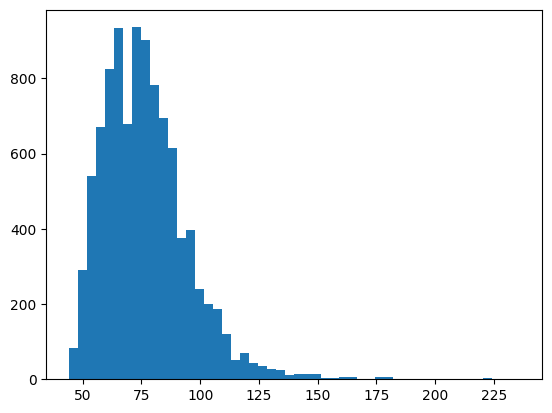

Max prompt length: 236
Max label length: 4


In [ ]:
find_max_length(mnli_mm_val)

In [ ]:
prompt_lengths, _ = get_lengths(mnli_mm_val)
df = pd.DataFrame(prompt_lengths, columns=["length"])
print("Number of examples that have over 256 tokens:",(df["length"] > 256).sum())

Number of examples that have over 256 tokens: 0


In [ ]:
# # Test run for mismatched
# mnli_mm_val_test = MNLIDataset(mnli_mm_val, tokenizer)
# mm_dataloader = DataLoader(mnli_mm_val_test, batch_size=4, shuffle=False)

# batch_sample = next(iter(mm_dataloader))
# input_ids = {k: v.to(model.device) for k, v in batch_sample.items() if k != "labels"}

# with torch.no_grad():
#     output = model.generate(**input_ids, max_new_tokens=20)

# out = tokenizer.batch_decode(output, skip_special_tokens=True)

# for text in out:
#     x = re.findall('[e|E]ntailment|[c|C]ontradiction|[n|N]eutral', text)
#     print(x[3])

contradiction
contradiction
entailment
neutral


In [ ]:
# Create checkpoint
checkpoint_dir = "drive/MyDrive/eval_checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
print("Checkpoint directory:", checkpoint_dir)

checkpoint_path = os.path.join(
    checkpoint_dir,
    f"checkpoint_mnli_mm_{model_id.split('/')[1]}.pt".replace('-', '_')
)

In [ ]:
from tqdm import tqdm

dataset_mm_test = MNLIDataset(mnli_m_val, tokenizer)
dataloader_mm = DataLoader(dataset_mm_test, batch_size=16, shuffle=False)

# Load checkpoint if it exists
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    predicted_labels = checkpoint["predicted_labels"]
    gold_labels = checkpoint["gold_labels"]
    no_answer = checkpoint["no_answer"]
    start_batch = checkpoint['batch_no']
    print(f"Checkpoint found. Continuing from batch #{start_batch}.")
else:
    gold_labels, predicted_labels = [], []
    start_batch = 0
    no_answer = 0
    print("No checkpoint found.")

with torch.no_grad():
    for i, batch in enumerate(tqdm(dataloader_mm, desc="Evaluating", unit="batch")):
        # Continue from last checkpoint
        if i < start_batch:
            continue

        input_ids_batch = batch["input_ids"].to(model.device) # Move to GPU
        attention_mask_batch = batch["attention_mask"].to(model.device) # Move to GPU
        gold_labels_batch = batch["labels"] # Keep to CPU

        # Get outputs
        outputs = model.generate(input_ids=input_ids_batch, attention_mask=attention_mask_batch, max_new_tokens=6)
        outputs_decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)

        predicted_labels_batch = extract_prediction(outputs_decoded, gold_labels_batch, no_answer)
        predicted_labels.extend(predicted_labels_batch)
        gold_labels.extend(gold_labels_batch)

        # Save checkpoint
        if i % 50 == 0 or i == len(dataloader_mm):
            torch.save({"predicted_labels": predicted_labels,
                        "gold_labels": gold_labels,
                        "no_answer": no_answer,
                        "batch_no": i+1}, checkpoint_path)

            print(f"Checkpoint saved: {i+1}, {checkpoint_path}")